In [2]:
import MySegments
import MyVisualiser
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.externals import joblib

import os
from os import path
from os import mkdir
from os import listdir
from os.path import isfile, join


import itertools
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib

from matplotlib.ticker import ScalarFormatter

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm*100 if normalize else cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]*100, fmt) if normalize else format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   # plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plot_learning_curve(model, train_sizes, train_scores, valid_scores, ax):
  #  plt.figure('train_size')
    
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()
    ax.set_ylim(ymin=0.17, ymax=1.03)    
    
    ax.plot(train_sizes,np.mean(train_scores, axis = 1), '-', label ='train scores')
    ax.fill_between(x=train_sizes,
                         y1=np.mean(train_scores, axis = 1)-np.std(train_scores, axis = 1),
                         y2=np.mean(train_scores, axis = 1)+np.std(train_scores, axis = 1), 
                         alpha =0.2, interpolate = True)
    
    ax.plot(train_sizes,np.mean(valid_scores, axis = 1), '-', label ='validation scores')
    ax.fill_between(x=train_sizes,
                         y1=np.mean(valid_scores, axis = 1)-np.std(valid_scores, axis = 1),
                         y2=np.mean(valid_scores, axis = 1)+np.std(valid_scores, axis = 1),
                         alpha =0.2, interpolate = True)
    
    ax.legend(loc='lower right')    
    ax.set_xscale('log')
    ax.set_xticks([0.02,0.05,0.1,0.2,0.5,1.0])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    ax.set_title('Learning curve - ' + model)
    ax.set_xlabel('Train-test-ratio')
    ax.set_ylabel('Accuracy')  

In [5]:
def plot_test_time(model, df,ax, default_cv):
    #Plotting the the accuracy over number of features
    #Get best mean_train_score per Selection Method and number of features
    df_m = (df.assign(rn=df.sort_values(['rank_test_score'], ascending=True)
                .groupby(['reducer','n_features'])
                .cumcount()+1)
                .query('rn<2')
    )
    reducers = df_m['reducer'].drop_duplicates().tolist()
    COLORS = 'bgrcmyk'  
    
    for color,reducer_label in zip(COLORS,reducers):
        if reducer_label != '': #Labels to exclude!
            reducer = df_m[df_m['reducer'] == reducer_label][['n_features','mean_score_time','mean_fit_time', 'std_score_time', 'std_fit_time']]
            reducer = reducer.sort_values('n_features')
            
            #----threshold for standard SVM
            ax.axhline(y = default_cv.sort_values(['rank_test_score'], ascending = True)['mean_fit_time'].head(1).values, 
               linestyle='--', alpha=0.7, color='black', label='default SVM')

            #----score and fit time
            ax.plot(reducer['n_features'],reducer['mean_score_time'], '-', label='score time')  
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_score_time']-reducer['std_score_time'], 
                             y2=reducer['mean_score_time']+reducer['std_score_time'],
                             alpha =0.2, interpolate = True)
            
            ax.plot(reducer['n_features'],reducer['mean_fit_time'], '-', label='fit time')
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_fit_time']-reducer['std_fit_time'], 
                             y2=reducer['mean_fit_time']+reducer['std_fit_time'],
                             alpha =0.2, interpolate = True)
            
            

  #  plt.tight_layout()
    ax.legend(loc='best')
    ax.set_title('Performance - ' + model)
    ax.set_xlabel('Number of Features')
    ax.set_xscale('log')#, base=2)
    ax.set_xticks([1,2,5,10,20,50,100,200,500])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    ax.set_ylabel('Time in seconds')
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()

In [6]:
def plot_test_accuracy(model, df,ax, default_cv):
    #Plotting the the accuracy over number of features
    #Get best mean_train_score per Selection Method and number of features
    df_m = (df.assign(rn=df.sort_values(['rank_test_score'], ascending=True)
                .groupby(['reducer','n_features'])
                .cumcount()+1)
                .query('rn<2')
    )
    reducers = df_m['reducer'].drop_duplicates().tolist()
    COLORS = 'bgrcmyk'  
    
    for color,reducer_label in zip(COLORS,reducers):
        if reducer_label != '': #Labels to exclude!
            reducer = df_m[df_m['reducer'] == reducer_label][['n_features','mean_test_score','std_test_score']]
            reducer = reducer.sort_values('n_features')

            #----threshold for standard SVM
            ax.axhline(y = default_cv.sort_values(['rank_test_score'], ascending = True)['mean_test_score'].head(1).values, 
                       linestyle='--', alpha=0.7, color='black', label='default SVM')
            
            #----full line for mean
            ax.plot(reducer['n_features'],reducer['mean_test_score'], '-', label=model)  
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_test_score']-reducer['std_test_score'], 
                             y2=reducer['mean_test_score']+reducer['std_test_score'],
                             alpha =0.2, interpolate = True)

    ax.legend(loc='lower right')
    #ax.set_title('Prediction Performance - ' + model)
    ax.set_xlabel('Number of Features')
    ax.set_xscale('log')#, base=2)
    ax.set_xticks([1,2,5,10,20,])#50,100,200,500])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.set_ylim(ymin=0.25, ymax=1)
    
    ax.set_ylabel('Accuracy')
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()

In [39]:
def plot_test_accuracy(model, df,ax):
    #Plotting the the accuracy over number of features
    #Get best mean_train_score per Selection Method and number of features
    df_m = (df.assign(rn=df.sort_values(['rank_test_score'], ascending=True)
                .groupby(['reducer','n_features'])
                .cumcount()+1)
                .query('rn<2')
    )
    reducers = df_m['reducer'].drop_duplicates().tolist()
    COLORS = 'bgrcmyk'  
    
    for color,reducer_label in zip(COLORS,reducers):
        if reducer_label != '': #Labels to exclude!
            reducer = df_m[df_m['reducer'] == reducer_label][['n_features','mean_test_score','std_test_score']]
            reducer = reducer.sort_values('n_features')
            
            #----full line for mean
            ax.plot(reducer['n_features'],reducer['mean_test_score'], '-', label=model)  
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_test_score']-reducer['std_test_score'], 
                             y2=reducer['mean_test_score']+reducer['std_test_score'],
                             alpha =0.2, interpolate = True)

    ax.legend(loc='lower right')
    #ax.set_title('Prediction Performance - ' + model)
    ax.set_xlabel('Number of Features')
    ax.set_xscale('log')#, base=2)
    ax.set_xticks([1,2,5,10,20,50,100,200,500])#,750])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    #ax.set_ylim(ymin=0.25, ymax=1)
    
    ax.set_ylabel('Accuracy')
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()

In [40]:
models = ['None','LDA', 'FastICA','Select_ANOVA', 'Select_Chi2', 'Select_Mutual_Info']
model_labels = ['default SVM', 'LDA', 'ICA', 'F-Score', 'Chi Square', 'Mutual Information']

models = ['None','Select_ANOVA', 'Select_Chi2', 'Select_Mutual_Info']
model_labels = ['default SVM', 'F-Score', 'Chi Square', 'Mutual Information']

#models = ['None','LDA', 'FastICA']
#model_labels = ['default SVM', 'LDA', 'FastICA']

clfs = []
cv_results = []

#load best estimators and cv results
for model in models:    
    for file in os.listdir('./Results_CV9/'+ model):
        if file.endswith('.pkl'):
            #print(os.path.join('./Results/' + model, file))
            clfs.append(joblib.load(os.path.join('./Results_CV9/' + model, file)))
            print(joblib.load(os.path.join('./Results_CV9/' + model, file)))
        if file.endswith('.csv'):
            cv_results.append(pd.read_csv(os.path.join('./Results_CV9/' + model, file), sep='\t'))#, header=1))

#Load Data
mypath = 'Test'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
#Get labelled data
sc = MySegments.SegmentCollection(folder = mypath, segments_path=onlyfiles, labels_path = 'labels.csv', classes_path='class_names.csv')
idx,X,y = sc.get_labelled()

#split train and test data, maintaining class distributions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)



#grid = GridSearchCV(pipe, cv=3, n_jobs=2, param_grid=param_grid, return_train_score = True, verbose=10)

Pipeline(memory=Memory(cachedir='/tmp/py_sklearn_tmponmam5tz\\joblib'),
     steps=[('variance_thresh', VarianceThreshold(threshold=0.0)), ('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('classify', SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Pipeline(memory=Memory(cachedir='/tmp/py_sklearn_tmpzi5v0idd\\joblib'),
     steps=[('variance_thresh', VarianceThreshold(threshold=0.0)), ('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('reduce_dim', SelectKBest(k=325, score_func=<function f_classif at 0x0E7E1150>)), ('classify', SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=Fa

In [53]:
train_sizes, train_scores, valid_scores = learning_curve( 
    clf, X_train, y_train, train_sizes=np.logspace(-1.5, 0,8), cv=2, n_jobs=1)



In [57]:
lc = pd.DataFrame()
lc['train_sizes'] = train_sizes
lc['train_scores'] = np.mean(train_scores, axis=1)
lc['valid_scores'] = np.mean(valid_scores,axis=1)
#lc.to_csv(model + '_learning_curve.csv') 

In [59]:
np.mean(train_scores,axis=1)

array([1.        , 0.99315068, 0.99159664, 0.97948718, 0.9765625 ,
       0.96190476, 0.9622093 , 0.95283688])

In [45]:
def plot_test_time(model, df,ax):
    #Plotting the the accuracy over number of features
    #Get best mean_train_score per Selection Method and number of features
    df_m = (df.assign(rn=df.sort_values(['rank_test_score'], ascending=True)
                .groupby(['reducer','n_features'])
                .cumcount()+1)
                .query('rn<2')
    )
    reducers = df_m['reducer'].drop_duplicates().tolist()
    COLORS = 'bgrcmyk'  
    
    for color,reducer_label in zip(COLORS,reducers):
        if reducer_label != '': #Labels to exclude!
            reducer = df_m[df_m['reducer'] == reducer_label][['n_features','mean_score_time','mean_fit_time', 'std_score_time', 'std_fit_time']]
            reducer = reducer.sort_values('n_features')


            #----score and fit time
       #     ax.plot(reducer['n_features'],reducer['mean_score_time'], '-', label=model +' score time')  
       #     ax.fill_between(x=reducer['n_features'], 
       #                      y1=reducer['mean_score_time']-reducer['std_score_time'], 
       #                      y2=reducer['mean_score_time']+reducer['std_score_time'],
       #                      alpha =0.2, interpolate = True)
            
            ax.plot(reducer['n_features'],reducer['mean_fit_time'], '-', label=model +' fit time')
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_fit_time']-reducer['std_fit_time'], 
                             y2=reducer['mean_fit_time']+reducer['std_fit_time'],
                             alpha =0.2, interpolate = True)
            
            

  #  plt.tight_layout()
    ax.legend(loc='best')
    #ax.set_title('Performance )
    ax.set_xlabel('Number of Features')
    ax.set_xscale('log')#, base=2)
    ax.set_xticks([1,2,5,10,20,50,100,200,500])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    ax.set_ylabel('Time in seconds')
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()

In [46]:
import datetime
now = datetime.datetime.now()

In [47]:
print('----GridSearch Cross-Validation Score----')
for model, clf, cv_result in zip(models, clfs, cv_results):    
    print(model, cv_result.sort_values(['rank_test_score'], ascending=True)['mean_test_score'].head(1).values)

print('----Performance on Unseen Data----')
#for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):   
#    clf.fit(X_train,y_train)
#    print(model, clf.score(X_test, y_test))  

----GridSearch Cross-Validation Score----
None [0.8496813]
Select_ANOVA [0.91595845]
Select_Chi2 [0.92162417]
Select_Mutual_Info [0.9167847]
----Performance on Unseen Data----


----Accuracy----


<Figure size 432x288 with 0 Axes>

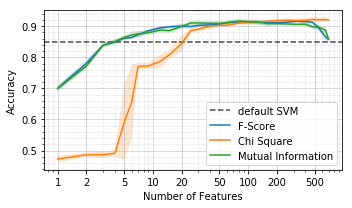

<Figure size 432x288 with 0 Axes>

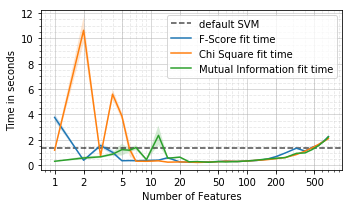

In [48]:
print('----Accuracy----')
#fig, ax = plt.subplots(nrows=1,ncols=3, num='accuracy', figsize=(14,4))
default_model = models[0]
default_clf = clfs[0]
default_cv = cv_results[0]
plt.clf()
fig, ax = plt.subplots(nrows=1,ncols=1, num='test_accuracy', figsize=(5,3))
#----threshold for standard SVM
ax.axhline(y = default_cv.sort_values(['rank_test_score'], ascending = True)['mean_test_score'].head(1).values, 
           linestyle='--', alpha=0.7, color='black', label='default SVM')
for i,(model, clf, cv_result, label) in enumerate(zip(models, clfs, cv_results, model_labels)):
    if i != 0:
        plot_test_accuracy(label, cv_result, ax)
fig.tight_layout()

#plt.savefig('compare_accuracy_' + now.strftime("%Y-%m-%d_%H-%M") + '.png', dpi= 300)
plt.show()


plt.clf()
fig, ax = plt.subplots(nrows=1,ncols=1, num='test_time', figsize=(5,3))
            
#----threshold for standard SVM
ax.axhline(y = default_cv.sort_values(['rank_test_score'], ascending = True)['mean_fit_time'].head(1).values, 
   linestyle='--', alpha=0.7, color='black', label='default SVM')
for i,(model, clf, cv_result, label) in enumerate(zip(models, clfs, cv_results, model_labels)):
    if i != 0:
        plot_test_time(label, cv_result, ax)
fig.tight_layout()

plt.savefig('compare_fit_time_' + now.strftime("%Y-%m-%d_%H-%M") + '.png', dpi=300)
plt.show()
    

----Accuracy----


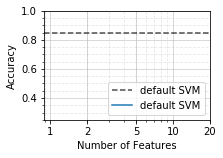

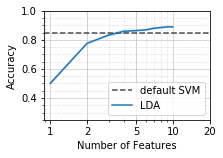

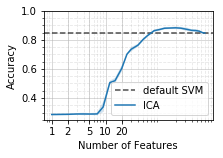

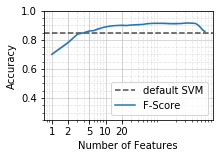

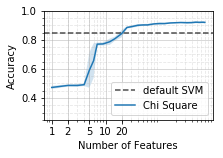

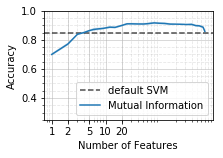

In [10]:
print('----Accuracy----')
#fig, ax = plt.subplots(nrows=1,ncols=3, num='accuracy', figsize=(14,4))
default_model = models[0]
default_clf = clfs[0]
default_cv = cv_results[0]
for i,(model, clf, cv_result, label) in enumerate(zip(models, clfs, cv_results, model_labels)):
    plt.clf()
    fig, ax = plt.subplots(nrows=1,ncols=1, num='test_time', figsize=(3.2,2.3))
    plot_test_accuracy(label, cv_result, ax, default_cv)
    fig.tight_layout()
   # if label == 'LDA':
   #     plt.savefig( model + '_accuracy_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
    plt.show()
    
    

    

----Test Time----


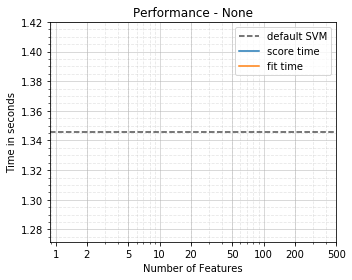

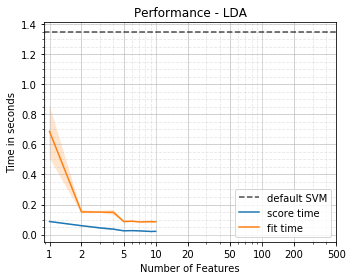

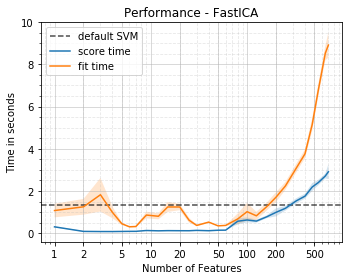

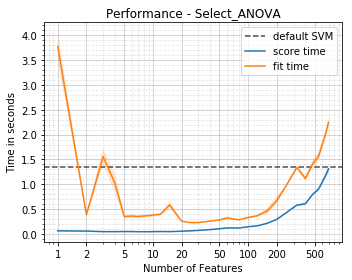

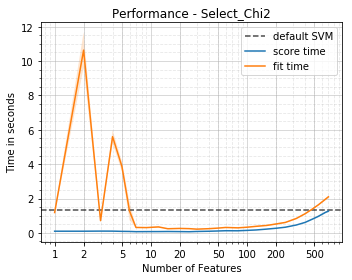

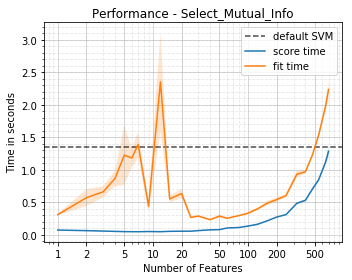

In [15]:
default_model = models[0]
default_clf = clfs[0]
default_cv = cv_results[0]
#plot individually    
print('----Test Time----')
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plt.clf()
    fig, ax = plt.subplots(nrows=1,ncols=1, num='test_time', figsize=(5,4))
    plot_test_time(model, cv_result, ax, default_cv)
    fig.tight_layout()
    #plt.savefig(model + '_performance_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
    plt.show()
    


In [ ]:
print('----Learning Curves----')
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plt.clf()
    fig, ax = plt.subplots(nrows=1,ncols=1, num='learning_curves', figsize=(5,4))
    # compute learnung curve
    train_sizes, train_scores, valid_scores = learning_curve( 
        clf, X_train, y_train, train_sizes=np.logspace(-1.5, 0,8), cv=6)
    
    # plot learning curves
    plot_learning_curve(model, train_sizes/np.shape(X_train)[0], train_scores, valid_scores, ax)
    fig.tight_layout()
    plt.savefig(model + '_learning_curves_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
#plt.show()

print('----Confusion Matrices----')

for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plt.clf()
    plt.figure('confusion_matrices', figsize=(5,4))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,clf.fit(X_train,y_train).predict(X_test) )
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,12], normalize=True,
                          title='Normalized confusion matrix - ' + model)
    plt.tight_layout()
    plt.savefig(model + '_confusion_matrices_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
#plt.show()

----Test Time----


IndexError: index 3 is out of bounds for axis 0 with size 3

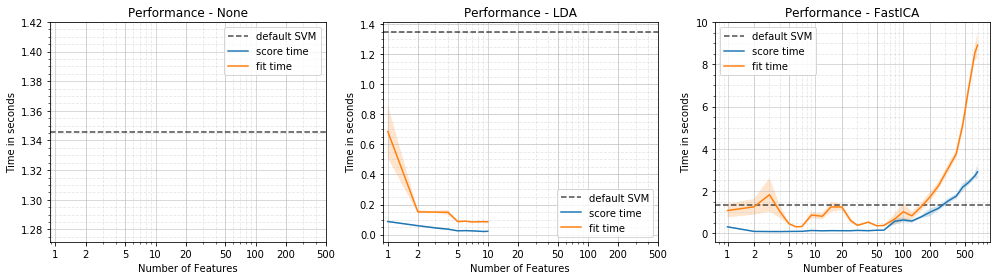

In [13]:
#plot together        
print('----Test Time----')
fig, ax = plt.subplots(nrows=1,ncols=3, num='test_time', figsize=(14,4))
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plot_test_time(model, cv_result, ax[i], default_cv)
    fig.tight_layout()
#plt.savefig('performance_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
plt.show()
    
print('----Learning Curves----')
fig, ax = plt.subplots(nrows=1,ncols=3, num='learning_curves', figsize=(14,4))

for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    # compute learnung curve
    train_sizes, train_scores, valid_scores = learning_curve( 
        clf, X_train, y_train, train_sizes=np.logspace(-1.5, 0,8), cv=6)
    
    # plot learning curves
    plot_learning_curve(model, train_sizes/np.shape(X_train)[0], train_scores, valid_scores, ax[i])
    fig.tight_layout()
#plt.savefig('learning_curves_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
plt.show()

print('----Confusion Matrices----')
plt.figure('confusion_matrices', figsize=(16,4))
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,clf.fit(X_train,y_train).predict(X_test) )
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.subplot(1,3,i+1)
    plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,12], normalize=True,
                          title='Normalized confusion matrix - ' + model)
    plt.tight_layout()
#plt.savefig('confusion_matrices_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
plt.show()

In [5]:
# Perform the classification and prediction
idx_train, X_train,y_train = sc.get_labelled()
idx_test, X_test, y_test = sc.get_unlabelled()
idx_all, X_all, y_all = sc.get_all()

import datetime
now = datetime.datetime.now()

for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    outframe = pd.DataFrame()
    outframe['sys_idx'] = idx_all
    outframe['predicted_label'] = clf.fit(X_train,y_train).predict(X_all)

    
    filename='prediction_' + model + '_' + now.strftime("%Y-%m-%d_%H-%M") + '.csv' 
    outframe.to_csv(filename) 
    print('prediction saved to: ', filename)

prediction saved to:  prediction_None_2018-05-03_14-43.csv
prediction saved to:  prediction_LDA_2018-05-03_14-43.csv
prediction saved to:  prediction_FastICA_2018-05-03_14-43.csv


In [6]:
np.shape(X_all)

(81089, 88)